In [1]:
import tensorflow as tf

# 定义变量
x = tf.Variable(1.)
total = tf.Variable(0.)

sum_op = total.assign(x + total)
add_op = x.assign(x+1)

for i in range(100):
    total = total + x
    x = x+1
# 输出total的值
print(total.numpy())


5151.0


# 什么是神经网络模型
是放着了人脑中神经网络的特征而构建的模型。在人的大脑中，由众多神经元，由它们相互交织组成的网络就是神经网络。当外界信息输入时，人脑中的神经网络可以通过
神经元之间的相互协作完成信息的传递，并在最后输出结果用于决策。而神经网络模型则是借鉴了其中的信息传递与处理的关系，以用于解决机器学习领域中常见的问题。
由于现实中问题的复杂性，所以神经网络模型一般需要通过大量的样本来训练，以学习得到可以用来推理的能力，从而来解决一些常见的分类或回归问题。


In [2]:
# 训练集和测试集的划分
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  tushare as ts
from sklearn.preprocessing import MinMaxScaler

In [11]:
# 为了将数据统一到一定范围内并加快模型的训练速度，我们需要通过前面导入的MinMaxScaler类来实现数据的归一化处理。通过归一化处理，所有的数据就
#落在了0到1的范围内了。其中，通过MinMaxScaler类的实例化对象对其进行归一化时，需要传入指定格式的数据，即[n_samples, n_features]，表示为n_sample
#行样本，n_features列特征的二维数组，所以首先通过np.reshape()函数将数据的shape转换为指定的格式，然后通过fit_transform()函数对其进行转换，最后
# 再将数据的shape转换为之前的形态



In [105]:
def get_data():
    ts.set_token("5bc162559b5b797dd8e5ec328db5c0f7ee2a2fc0c7f950652a5706a3")
    # 初始化接口,初始化后就可以通过Tushare提供的方法来获取历史数据了
    ts_pro = ts.pro_api()
    # ts_pro._DataApi__http_url = "http://tsapi.majors.ltd:7000"
    df = ts_pro.daily(
        # api=ts_pro,
        ts_code="000005.SZ",
        start_date="20220101",
        end_date="20231201",
        # fields="ts_code, trade_date,open,high,low,close,vol",
    )
    df = df.reindex(index=df.index[::-1])
    # 获取收盘价
    arr = df["close"].values
    # 归一化处理
    arr = np.reshape(arr, newshape=(-1, 1))
    mm = MinMaxScaler()
    arr = mm.fit_transform(arr)
    arr = np.reshape(arr, newshape=(-1))
    # 特征提取及标注标签
    X = []
    Label = []
    window_len = 12
    # 遍历数组
    for i in range(len(arr) - window_len -1):
        X.append(arr[i:i+window_len])
        Label.append(arr[i+window_len])
    X = np.array(X)
    Label = np.array(Label)
    # 划分训练集和测试集
    X_train = X[:-150]
    Label_train = Label[:-150]
    X_test = X[-150:]
    Label_test = Label[-150:]
    return X_train, Label_train, X_test, Label_test


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 12, 1)             0         
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 1s 2ms/step - loss: 0.0458
Epoch 2/100
10/10 [==============================] - 0s 2ms/step -

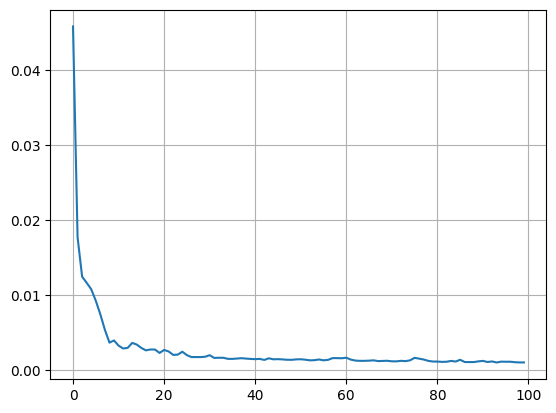

5/5 [==============================] - 0s 1ms/step


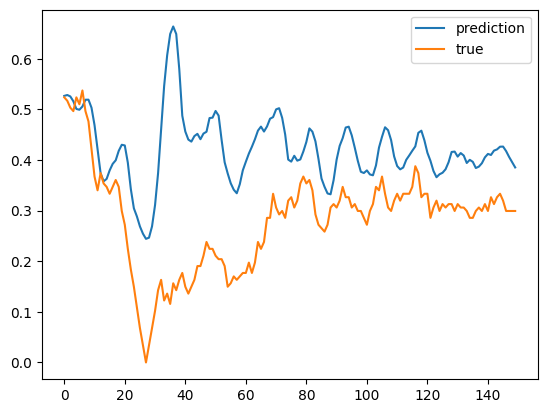

3497.7012380371702


In [106]:
# 窗口大小
windows_len = 12
# 隐藏层神经元个数
hidden_units = 64
# 构建模型结构
model_layers = [
    tf.keras.layers.Reshape((windows_len, 1), input_shape=(windows_len,)),
    tf.keras.layers.SimpleRNN(units=hidden_units, return_sequences=False),
    tf.keras.layers.Dense(units=hidden_units, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# 构建模型
model = tf.keras.models.Sequential(model_layers)
print(model.summary())
X_train, Label_train, X_test, Label_test = get_data()
# 模型编译
model.compile(optimizer="adam", loss="mean_squared_error")
# 模型训练
history = model.fit(X_train, Label_train, epochs=100)


# 可视化loss
def plot_loss(loss):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(loss)), loss)
    plt.grid(True)
    plt.show()


# 可视化loss
plot_loss(history.history["loss"])
def plot_result(prediction, true):
    """可视化预测值和真实值"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(prediction)), prediction)
    ax.plot(range(len(true)), true)
    ax.legend(["prediction", "true"])
    plt.show()

# 模型预测
prediction = model.predict(X_test)
# 可视化预测和真实值
plot_result(prediction, Label_test)
print(np.sum(np.abs(prediction - Label_test)))

In [107]:
# 根据预测的价格变化来决定买入和卖出
hold = False
money = 100
hold_stock_price = 0
for i in range(1, len(prediction)):
    predict_price = prediction[i]
    true_price = Label_test[i]
    yestoday_price = Label_test[i - 1]
    predict_yestoday_price = prediction[i - 1]
    if hold == False and predict_yestoday_price < predict_price:
        money -= yestoday_price
        hold_stock_price = yestoday_price
        hold = True
        print("buy", yestoday_price)
    elif hold == True and predict_yestoday_price > predict_price:
        money += yestoday_price
        hold = False
        hold_stock_price = 0
        print("sell", yestoday_price)
money += hold_stock_price
print(money)

buy 0.5238095238095237
sell 0.5170068027210883
buy 0.510204081632653
sell 0.47619047619047605
buy 0.3537414965986394
sell 0.29931972789115635
buy 0.0
sell 0.15646258503401356
buy 0.14965986394557818
sell 0.19047619047619047
buy 0.19047619047619047
sell 0.2108843537414966
buy 0.16326530612244894
sell 0.22448979591836737
buy 0.23809523809523814
sell 0.29251700680272097
buy 0.3265306122448979
sell 0.30612244897959173
buy 0.3197278911564625
sell 0.3605442176870748
buy 0.30612244897959173
sell 0.3265306122448979
buy 0.2857142857142856
sell 0.27210884353741505
buy 0.3129251700680271
sell 0.33333333333333326
buy 0.3197278911564625
sell 0.3265306122448979
buy 0.3197278911564625
sell 0.29931972789115635
buy 0.3129251700680271
sell 0.30612244897959173
buy 0.29931972789115635
sell 0.2857142857142856
buy 0.29931972789115635
sell 0.29931972789115635
buy 0.3265306122448979
sell 0.3197278911564625
100.24489795918369


In [104]:
# 根据预测的价格变化来决定买入和卖出
hold = False
money = 100
hold_stock_price = 0
for i in range(1, len(prediction)):
    predict_price = prediction[i]
    true_price = Label_test[i]
    yestoday_price = Label_test[i - 1]
    predict_yestoday_price = prediction[i - 1]
    if hold == False and yestoday_price < predict_price:
        money -= yestoday_price
        hold_stock_price = yestoday_price
        hold = True
        print("buy", yestoday_price)
    elif hold == True and yestoday_price > predict_price:
        money += yestoday_price
        hold = False
        hold_stock_price = 0
        print("sell", yestoday_price)
money += hold_stock_price
print(money)

buy 0.3924731182795699
sell 0.3763440860215054
buy 0.33333333333333337
sell 0.29569892473118287
buy 0.27956989247311825
99.94623655913979


- ts_code="000001.SZ",
start_date="20100101",
end_date="20231201",
误差：1128.4121157483464
量化：100.02737226277371